## Sentiment analysis on Amazon-fine-food reviews using LSTM

In [64]:
import datetime as dt
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Flatten
from keras.layers import  GlobalMaxPool1D
from keras.layers.normalization import BatchNormalization
from sklearn import preprocessing
from array import array
from sklearn.preprocessing import LabelEncoder


### Connecting to the pre-processed sql-ite file 

In [3]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


### Preparing the data by using its temporal structure

In [4]:
# Convert timestamp to datetime.

Data['Time'] = Data[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sorted=Data.sort_index()

Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1999-10-08 05:30:00,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1999-10-25 05:30:00,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
1999-12-02 05:30:00,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
1999-12-06 05:30:00,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
2000-01-03 05:30:00,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


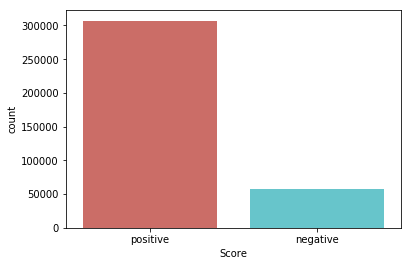

<Figure size 432x288 with 0 Axes>

In [5]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()
plt.savefig("count_plot")


### Utility function for plotting the error plot of LSTM network  

In [35]:
# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
    
# Plot weight distribution using violin plot
def plot_weights(model):
    w_after = model.get_weights()

    o1_w = w_after[0].flatten().reshape(-1,1)
    o2_w = w_after[2].flatten().reshape(-1,1)
    out_w = w_after[4].flatten().reshape(-1,1)


    fig = plt.figure(figsize=(10,7))
    plt.title("Weight matrices after model trained\n")
    plt.subplot(1, 3, 1)
    plt.title("Trained model\n Weights")
    ax = sns.violinplot(y=o1_w,color='b')
    plt.xlabel('Hidden Layer 1')

    plt.subplot(1, 3, 2)
    plt.title("Trained model\n Weights")
    ax = sns.violinplot(y=o2_w, color='r')
    plt.xlabel('Hidden Layer 2 ')

    plt.subplot(1, 3, 3)
    plt.title("Trained model\n Weights")
    ax = sns.violinplot(y=out_w,color='y')
    plt.xlabel('Output Layer ')
    plt.show()



### Processing the data by using Tokeneization and padding in keras

In [31]:
from  keras.preprocessing.text import Tokenizer
# defining the size of the vocabulary 5000 
max_Reviws = 5000 #Maximum length of the reviews to be taken
x = Sorted["CleanedText"]
y = polarity

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.33, random_state = None)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(Y_train)
test_y = encoder.fit_transform(Y_test)

# create the tokenizer
t = Tokenizer(num_words=max_Reviws, split=' ')
# fit the tokenizer on the documents
t.fit_on_texts(X_train)

#Using the Tokenizers API of keras 
list_tokenized_train = t.texts_to_sequences(X_train)
list_tokenized_test = t.texts_to_sequences(X_test)

In [45]:
t.word_counts

OrderedDict([('year', 25759),
             ('ago', 6474),
             ('product', 80140),
             ('disappear', 887),
             ('store', 31647),
             ('shelv', 871),
             ('thought', 11510),
             ('mayb', 6371),
             ('downgrad', 37),
             ('season', 6323),
             ('item', 11079),
             ('everi', 15925),
             ('trip', 2220),
             ('groceri', 10346),
             ('shop', 4150),
             ('final', 4338),
             ('given', 3272),
             ('hope', 7613),
             ('ever', 14936),
             ('find', 35781),
             ('search', 3737),
             ('net', 475),
             ('last', 13865),
             ('resort', 302),
             ('found', 23857),
             ('amazon', 40041),
             ('trust', 1358),
             ('level', 2749),
             ('low', 8948),
             ('first', 25381),
             ('could', 19049),
             ('didnt', 14344),
             ('come', 18031),

In [44]:

#Top 25 most frequent occurence of words
count=list(t.word_counts)
print(count[:25])


['year', 'ago', 'product', 'disappear', 'store', 'shelv', 'thought', 'mayb', 'downgrad', 'season', 'item', 'everi', 'trip', 'groceri', 'shop', 'final', 'given', 'hope', 'ever', 'find', 'search', 'net', 'last', 'resort', 'found']


In [47]:
t.word_index

{'like': 1,
 'tast': 2,
 'flavor': 3,
 'good': 4,
 'product': 5,
 'use': 6,
 'one': 7,
 'love': 8,
 'great': 9,
 'tri': 10,
 'tea': 11,
 'coffe': 12,
 'get': 13,
 'make': 14,
 'food': 15,
 'would': 16,
 'buy': 17,
 'time': 18,
 'realli': 19,
 'eat': 20,
 'amazon': 21,
 'order': 22,
 'dont': 23,
 'much': 24,
 'price': 25,
 'also': 26,
 'find': 27,
 'littl': 28,
 'bag': 29,
 'best': 30,
 'dog': 31,
 'even': 32,
 'well': 33,
 'drink': 34,
 'store': 35,
 'ive': 36,
 'better': 37,
 'box': 38,
 'chocol': 39,
 'mix': 40,
 'day': 41,
 'water': 42,
 'sugar': 43,
 'recommend': 44,
 'look': 45,
 'year': 46,
 'sweet': 47,
 'first': 48,
 'want': 49,
 'packag': 50,
 'cup': 51,
 'brand': 52,
 'give': 53,
 'found': 54,
 'purchas': 55,
 'high': 56,
 'think': 57,
 'treat': 58,
 'made': 59,
 'work': 60,
 'way': 61,
 'bought': 62,
 'enjoy': 63,
 'say': 64,
 'need': 65,
 'thing': 66,
 'know': 67,
 'delici': 68,
 'nice': 69,
 'review': 70,
 'differ': 71,
 'two': 72,
 'sinc': 73,
 'add': 74,
 'bit': 75,
 'pa

In [46]:
#Top 25 words according to the index position
#for index of words
index=list(t.word_index)
print(index[:25])

['like', 'tast', 'flavor', 'good', 'product', 'use', 'one', 'love', 'great', 'tri', 'tea', 'coffe', 'get', 'make', 'food', 'would', 'buy', 'time', 'realli', 'eat', 'amazon', 'order', 'dont', 'much', 'price']


###  Observations
<li>Here first a vocabulary is created which contains most frequent 5000 words in the whole dataset.After that by using the keras texts_to_sequences method following steps have taken place:</li>
<ol>
    <li>The frequency of each words which are present in the vocabulary is calculated in a tuple format.</li>
    <li>The words are arranged in a dictionary by assigning the index to the most frequent words in the vocabulary.</li></ol>
<li>But there is still a problem since the length of the reviews are not same throughout the data and batch training cannot be done on this type of data which can slow-up the whole training process.</li>
<li>One solution is to use the padding concept and make the length of all the reviews same to avoid the above problems and speed up the training time.</li>


In [13]:
#Defining the maximum length of the padding 
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [48]:
#Sample input of the train data
X_t[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [27]:
#Implementing the elastic-net regularization
reg=regularizers.l1_l2(l1=0.01, l2=0.01)

## Building the 5-Layer LSTM architecture model

In [ ]:
##create the sequential model
embedding_vecor_length = 32 #Total number of inputs size of the embedding layer 
model = Sequential()

#Embedding layer
model.add(Embedding(max_Reviws , embedding_vecor_length, input_length=maxlen))
model.add(BatchNormalization())
model.add(Dropout(0.3))

#First LSTM layer
model.add(LSTM(100 , return_sequences=True,bias_regularizer=reg))
model.add(Dropout(0.4))

#Second LSTM layer
model.add(LSTM(80 , return_sequences=True,bias_regularizer=reg))
model.add(Dropout(0.5))

#Third LSTM layer
model.add(LSTM(60 , return_sequences=True,bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.6))

#Fourth LSTM layer
model.add(LSTM(40 , return_sequences=True,bias_regularizer=reg))
model.add(Dropout(0.70))

#Fifth LSTM layer
model.add(LSTM(20 ))
model.add(BatchNormalization())
model.add(Dropout(0.50))

#Final dense layer
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(1, activation="sigmoid"))

#Compiling the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


###  Training the model over the train set

In [32]:
batch_size = 192
LSTM_5l=model.fit(X_t, train_y, epochs = 7, batch_size=batch_size, verbose = 2,validation_data=(X_te, test_y))

Train on 243994 samples, validate on 120177 samples
Epoch 1/7
 - 5204s - loss: 2.7172 - acc: 0.7912 - val_loss: 0.4748 - val_acc: 0.8428
Epoch 2/7
 - 5260s - loss: 0.4515 - acc: 0.8433 - val_loss: 0.4394 - val_acc: 0.8428
Epoch 3/7
 - 5125s - loss: 0.4375 - acc: 0.8434 - val_loss: 0.4364 - val_acc: 0.8428
Epoch 4/7
 - 5143s - loss: 0.4355 - acc: 0.8434 - val_loss: 0.4362 - val_acc: 0.8428
Epoch 5/7
 - 5157s - loss: 0.4353 - acc: 0.8434 - val_loss: 0.4361 - val_acc: 0.8428
Epoch 6/7
 - 5085s - loss: 0.4353 - acc: 0.8434 - val_loss: 0.4362 - val_acc: 0.8428
Epoch 7/7
 - 5117s - loss: 0.4353 - acc: 0.8434 - val_loss: 0.4362 - val_acc: 0.8428


### Final accuracy score on the test set

In [34]:
score = model.evaluate(X_te, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4361937159713344
Test accuracy: 0.8427985388228963


### Plotting the weights and error-plots 

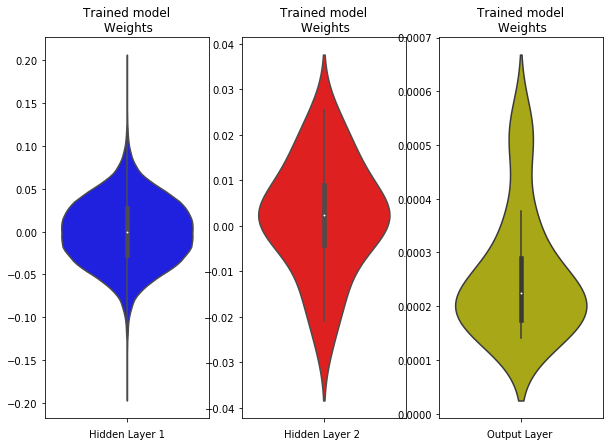

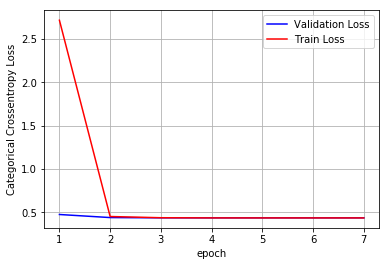

In [38]:
# Plot weight distribution using violin plot
import warnings
warnings.filterwarnings(action='ignore')
plot_weights(model)
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(LSTM_5l, 7)


<center><h1>Conclusion</h1></center>

<ul>
    <li>The input text data must be arranged in a proper format before feeding to the LSTM network.</li>
    <li>Building a proper network architecture is very much important in LSTM models which must be done very carefully.</li>
    <li>The train and test accuracy of the above 5-Layered LSTM model is about 84% which is good for a binary classification model but still can be improved if trained for larger epochs and layers.</li>
    <li>The above LSTM model is not over-fitting which can be seen on the above error plot and the model is very sensible and doing a very good job in classiffying the model properly.</li>
    <li>using the dropout and batch normalization layers reduces the high variance in the network and solves the problem of internal covariance-shift.</li>
    <li>But training an LSTM model is not a trivial task as it took me about 1.5 hrs for each epochs on C.P.U so thats why I trained for a smaller number of epochs.</li>